# DataLab Cup 3: Reverse Image Caption

IDUDL   
112062611吳明真 110062619楊淨富 112138502陳炫妙

<h2> Pick 5 descriptions from testing data and generate 5 images with different noise 𝑧 respectively

以下是我們從測試資料中選取的5個描述(助教DemoTA80的前五個)和這些描述對應的Index :
- 23 - flower with white long white petals and very long purple stamen 
- 216 - this medium white flower has rows of thin blue petals and thick stamen 
- 224 - this flower is white and purple in color with petals that are oval shaped 
- 413 - this flower is pink and yellow in color with petals that are oval shaped 
- 713 - the flower has a large bright orange petal with pink anther 

下圖是我們用不同的 random noise 所產生的結果，可以看到我們的model有產生出花的形狀以及一些可區別的顏色，在這之中Noise3產生的圖片應該較符合文字描述。而這裡Noise的產生是更改sample seed的iloc&scale來產生不同分布的noise，Noise5是用Inference，Noise1~4所利用的sample seed的iloc&scale值如下 :   
**Noise1 :** -0.8 0.8 ;  **Noise2 :** -1.0 1.2 ;  **Noise3 :** 0.0 1.0 ;  **Noise4 :** 1.0 1.2  
可以看出不同Noise對圖片的生成也有一些影響，好的Noise可以生成出比較好的圖片並且也長的較符合描述。

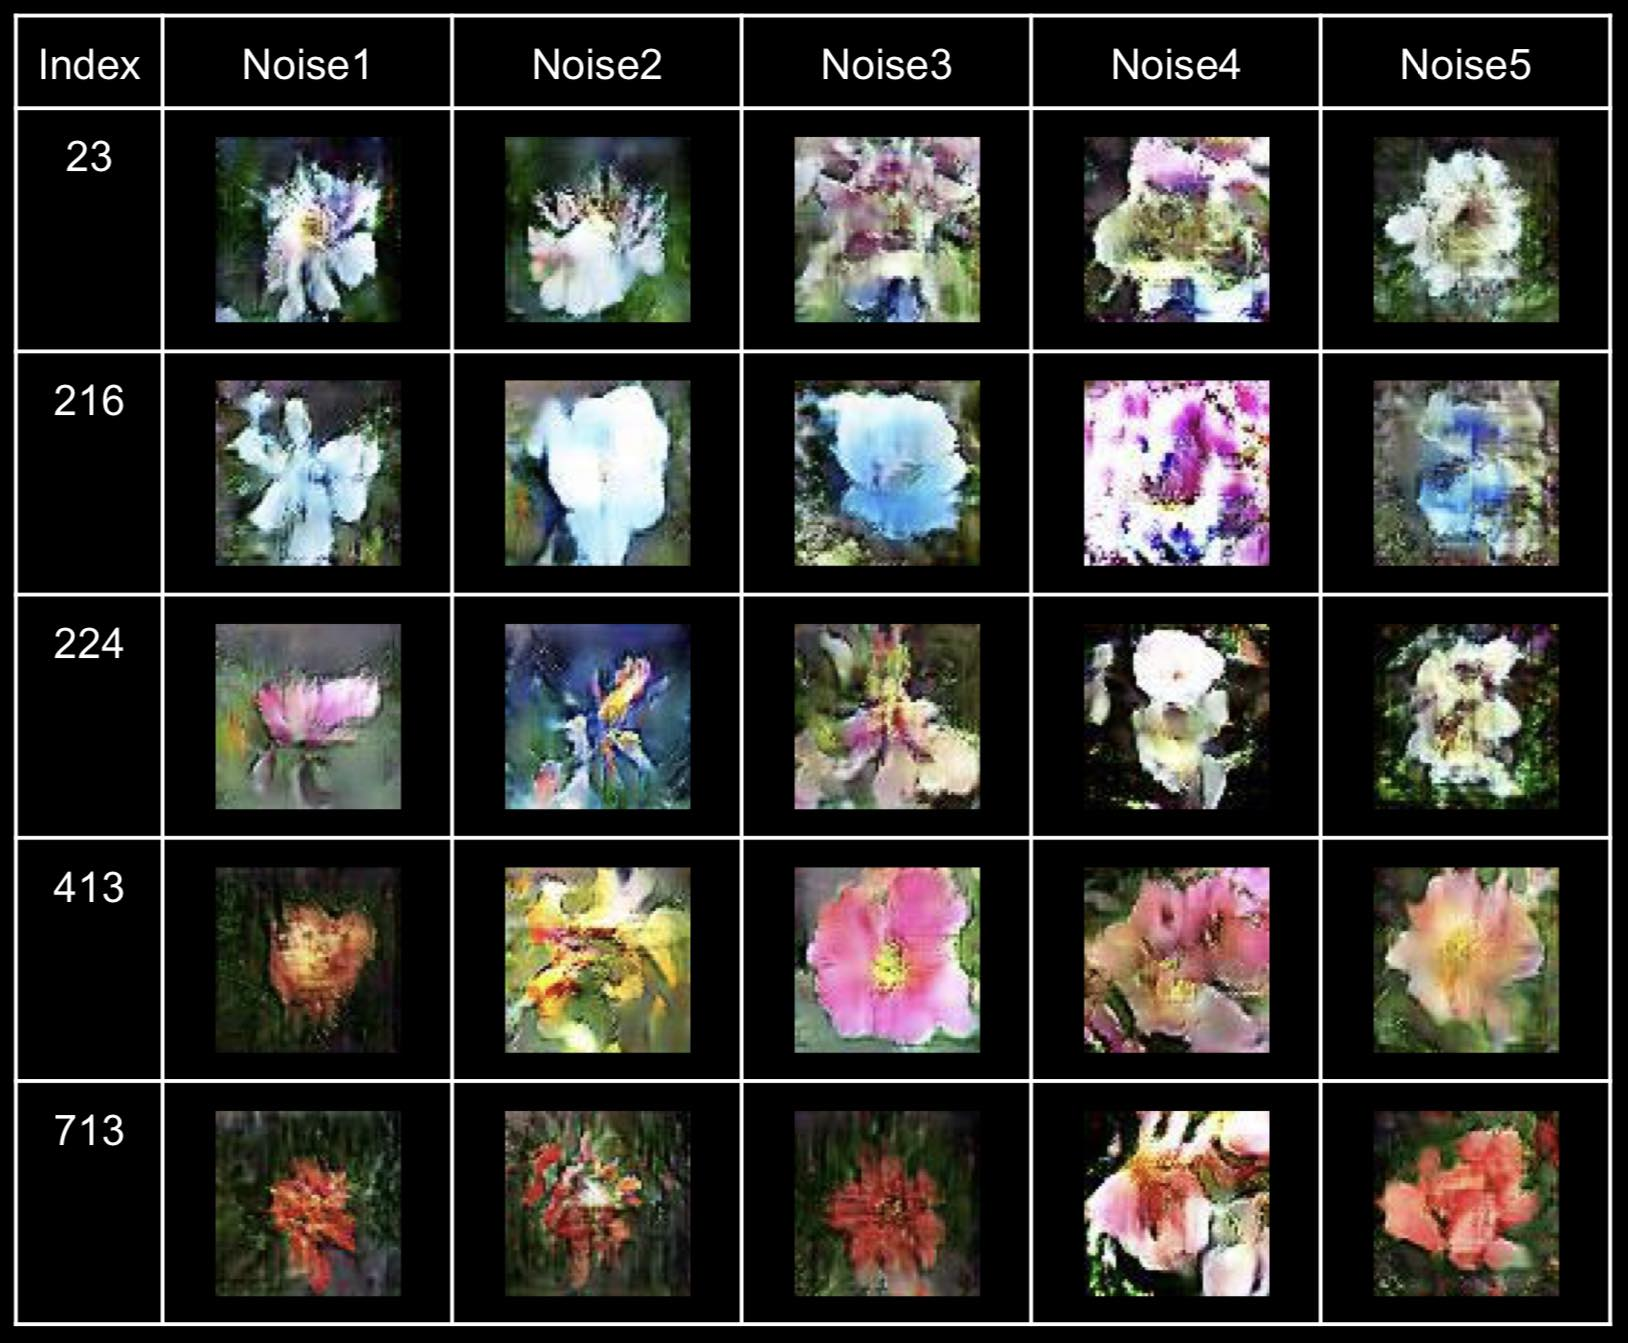

In [6]:
from IPython.display import Image 
img = Image(filename='test3.jpg', width=640, height=640)
display(img)

##  Models you tried during competition

### Data Preprocess & Dataset
基本上都是照著助教給的code執行，但我們有將所有 caption 加入訓練，資料及從七千多變七萬多。  
因應同張圖片會看到很多次，隨機對圖片做翻轉和亮度調整。  
增加資料集表現有稍微提升，並為了之後的 Text Encoder 將訓練資料檔的 caption 從數字又換回去文字。

### Text Encoder
提到textencoder自然就想到利用之前老師提到的RNN等等的text encoder將文字轉換成embedding，後來多google了之後發現有tensorflow內建的sentence encoder，所以就直接import tensorflow提供的universal sentence encoder幫助我們將句子變成embedding。

### Generator
嘗試過的 model :
* DCGAN
* Diffsion
* Stack GAN

最後的 model 是使用 Stack GAN 改良，但我們只來得及實作一個 stage ，並自己 add 一些額外的 layer。

在 generator 的部分都是先接 fc 再經過幾次的 upsampling，可以透過 Conv2DTranspose + Upsampling2D 達到。基本上按照原本 stackGAN 的架構，把 embedding 加上 noise 處理完之後經過好幾次 upsampling ，讓模型變得更深層，以此來提升表現。

接著嘗試各種組合，把 upsample 出來的 feature 和深淺層互相合併一下，看看可不可以產生出比較好的圖片。我們的最終架構 summary 放在 model.ipynb 最底部。

照著助教給的提示換過 relu or reaky_relu，以分數而言是後者表現較佳，也有參考《Generative Adversarial Text-to-Image Synthesis》的架構，但還是沒有比 Stack GAN 更出色，不過我們保留生成器用 Conv2DTranspose，判別器用 Conv2D 的設定。

而 deffusion model 有嘗試實作目前最好的 VQ-Deffsion，但實力不夠做不完，不過就目前看來 deffusion 應該是表現最好的。


### Discriminator
先將圖片經過conv得到feature map再將這個feature map經過額外的Conv來達到淺層和深層的feature合成，再將得到的結果和我們得到的text embedding合併，最後判斷這張圖片的真偽。

架構也是跟 gnerator 一樣，多塞了一堆 Conv2D layer 增加深度。

### Loss Function & Optimizer
- Loss :  
加入 **wrong caption** 計算錯誤敘述配對圖片的損失，讓判別器能識別錯誤的描述。使用 cross entropy 當作 function，最終 loss 由  
`(real + fake + wrong)` 組成。有嘗試過 `1:0.5:0.5` 等等各種權重組合，但表現沒有改變太多。

- Optimizer :  
按照助教之前的實驗使用 Adam，有試著改過 Beta1、Beta2，但很容易造成訓練破圖(後期產出的圖毫無意義看不出東西)  
最終設定是只更改 Beta1 = 0.5


### Train Step & Hyperparameter
* 加入 noise decay  
`noise_decay = 1 / (epoch + 1)` 圖片丟入判別器前，在前三十個 epoch，根據 epoch 數加入不同程度的雜訊，有小提升表現。

* D:G 比率為 5:1
* epoch 不高  
除了我們有擴展資料集外，這個模型訓練太多也不會變更好，反而最佳表現集中在30~50之間
* 配合 wrong caption loss   
將敘述往後挪十格，利用錯位造成錯誤配對，因為我們有擴展資料集
* 加入 gradient penalty  
參考 lab 作法

## List the experiment you did

- 基本上都寫在上面了，模型主要是調整層數組合，損失函數則是調整三個 loss 權重，訓練過程比較艱辛，learning rate 一改表現就差很多。  
- 也有改變 sample noise 的分布，發現 `N( 0.5, 0.5)`最好看，標準差控制多樣性，平均值控制圖的品質  
- 試過其他種類的 Text encoder ，例如 bert 等等，最後還是決定使用這個比較簡單  
- generator 按照 tips 測試過 Conv2D/Conv2DTranspose  
- discreminator 刪減過 conv2d 層，但效果變差於是加回去  

<h2> Anything worth mentioning.

在做 inference 時，就算設定一樣，每次出來的分數也會不一樣。  
GAN太難訓練了，總是有各種奇異的理由造成訓練失敗，尤其常常遇到破圖，圖片大小增加但卻是毫無內容的雜訊，甚至有早期 epoch 表現得比後期好的情況發生，而且用肉眼判別的圖片品質與分數檔有出入，老實說比上次競賽難多了。